In [20]:
# Install rpy2 if you haven't yet
# !pip install rpy2

# Load the R magic extension
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymatchit import MatchIt, load_lalonde

print("Environment Ready. R extension loaded.")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Environment Ready. R extension loaded.


In [21]:
# Load the standard Lalonde dataset included in your package
df = load_lalonde()

# Define the formula we will use in BOTH languages
# Note: We use specific binary columns (black, hispan) to ensure exact matrix parity
formula = "treat ~ age + educ + black + hispan + married + nodegree + re74 + re75"

print(f"Data Loaded: {df.shape}")

Data Loaded: (614, 10)


In [22]:
print("--- Running Python pymatchit ---")

# Initialize and Fit
py_model = MatchIt(
    df, 
    method='nearest', 
    distance='glm', 
    link='logit', 
    replace=False, 
    caliper=0.2,
    ratio=1,
    random_state=42
)

py_model.fit(formula)

# Get Results
py_matches = py_model.matches()
py_summary = py_model.summary(print_output=False)
py_matched_data = py_model.matched_data

print(f"Python Matched Pairs: {len(py_matches)}")

--- Running Python pymatchit ---
Performing nearest matching (ATT)...
Matching complete. 234 observations in matched set.
Python Matched Pairs: 117


In [23]:
%%R -i df -o r_match_summary -o r_n_matched

library(MatchIt)

print("--- Running R MatchIt ---")

m.out <- matchit(as.formula("treat ~ age + educ + black + hispan + married + nodegree + re74 + re75"),
                 data = df,
                 method = "nearest",
                 distance = "glm",
                 link = "logit",
                 replace = FALSE,
                 caliper = 0.2,
                 ratio = 1)

s.out <- summary(m.out)

# --- FIX HERE: Convert matrix to data.frame to preserve names for Python ---
r_match_summary <- as.data.frame(s.out$sum.matched)

r_n_matched <- nrow(match.data(m.out))
print(paste("R Matched Rows:", r_n_matched))

[1] "--- Running R MatchIt ---"
[1] "R Matched Rows: 226"


In [24]:
%%R -o r_match_matrix

# Get the matrix of matches (Row Names of Treated -> Row Names of Control)
# Note: MatchIt stores these as strings
r_match_matrix <- as.data.frame(m.out$match.matrix)
r_match_matrix$treated_index <- row.names(r_match_matrix)
colnames(r_match_matrix) <- c("control_index", "treated_index")

Total Matched Rows (Python): 234
Total Matched Rows (R):      226
Difference: 8 rows (4.0 pairs)
✅ OK: Sample sizes are comparable (within expected floating-point variance).

--- Balance Comparison (Standardized Mean Diff) ---
          Python SMD   R SMD  Difference
age           0.0108  0.0482     -0.0375
black         0.0469  0.0487     -0.0018
distance         NaN  0.1499         NaN
educ          0.0723  0.0528      0.0194
hispan       -0.0360 -0.0374      0.0014
married      -0.2176 -0.1356     -0.0821
nodegree      0.1500  0.1557     -0.0057
re74          0.0253 -0.0141      0.0394
re75          0.0119 -0.0503      0.0622


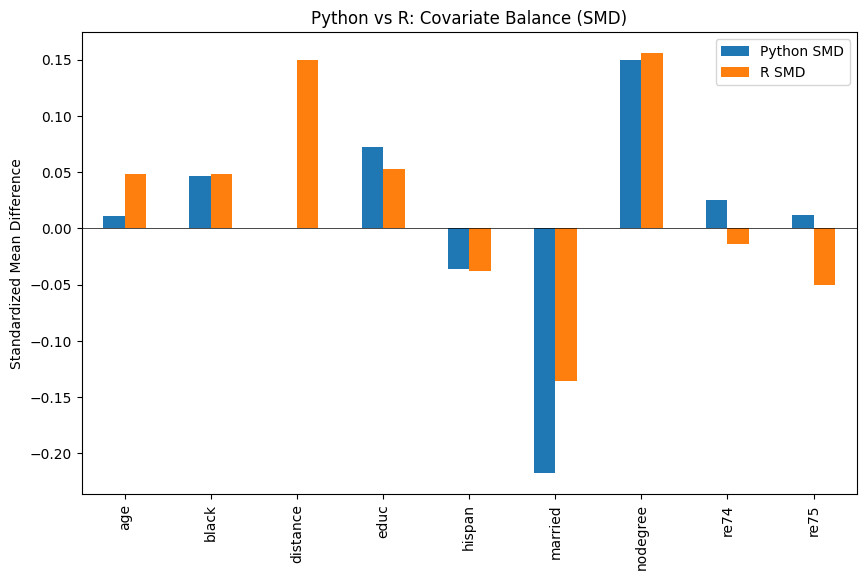

In [25]:
# 1. Compare Sample Sizes
n_py = len(py_matched_data)
n_r = r_n_matched[0] # rpy2 returns arrays

print(f"Total Matched Rows (Python): {n_py}")
print(f"Total Matched Rows (R):      {n_r}")

diff = abs(n_py - n_r)
print(f"Difference: {diff} rows ({diff/2:.1f} pairs)")

if diff > (0.05 * n_r): # Allow 5% variance
    print("⚠️ WARNING: Large discrepancy in sample size.")
else:
    print("✅ OK: Sample sizes are comparable (within expected floating-point variance).")

# 2. Compare Balance (Standardized Mean Differences)
# Extract R's SMD column
r_smd = pd.Series(r_match_summary['Std. Mean Diff.'], index=r_match_summary.index)

# Extract Python's SMD column
py_smd = py_summary['matched']['Std. Mean Diff.']

# Combine into one dataframe for easy viewing
comparison = pd.DataFrame({
    'Python SMD': py_smd,
    'R SMD': r_smd,
    'Difference': py_smd - r_smd
})

print("\n--- Balance Comparison (Standardized Mean Diff) ---")
print(comparison.round(4))

# 3. Visual Check
comparison[['Python SMD', 'R SMD']].plot(kind='bar', figsize=(10, 6))
plt.title("Python vs R: Covariate Balance (SMD)")
plt.ylabel("Standardized Mean Difference")
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

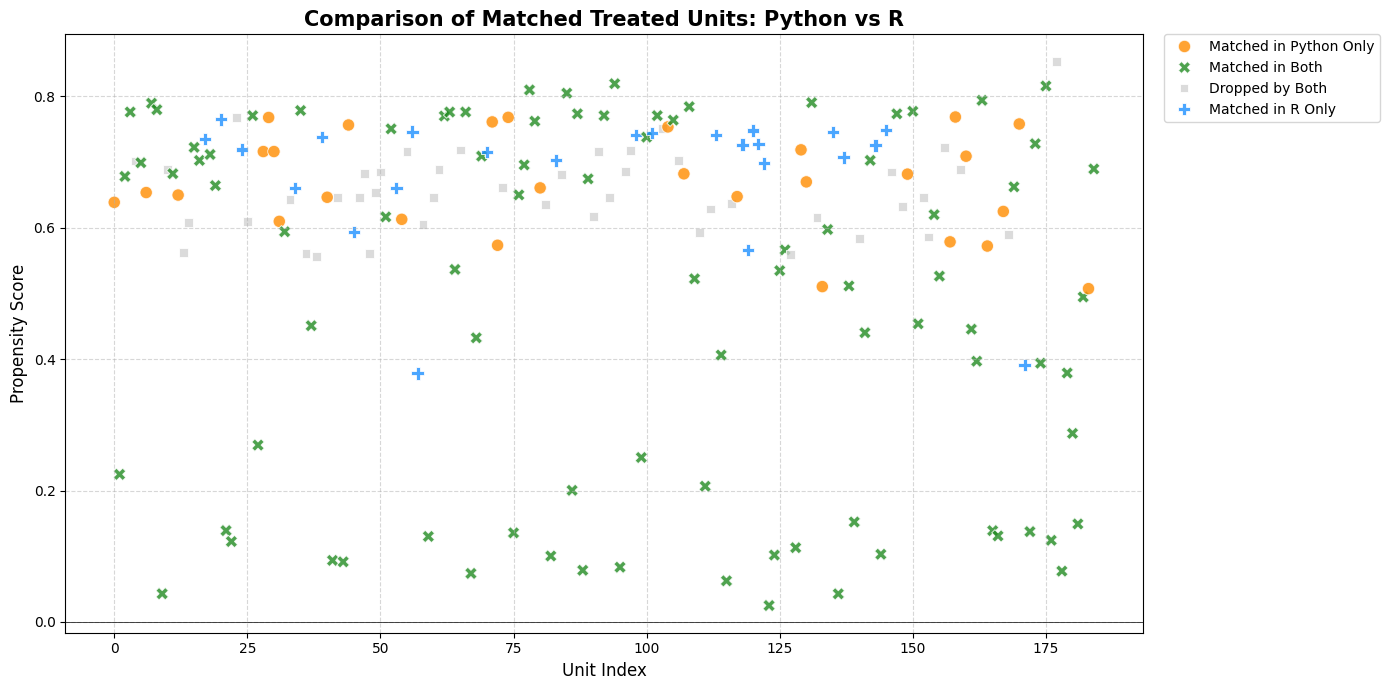

Match Status
Matched in Both           89
Dropped by Both           44
Matched in Python Only    28
Matched in R Only         24
Name: count, dtype: int64


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identify the universe of Treated units
# We use py_model.data because it contains the calculated propensity scores
treated_data = py_model.data[py_model.data['treat'] == 1].copy()

# 2. Assign Status to each unit
def get_status(idx):
    in_r = idx in r_treated_set
    in_py = idx in py_treated_set
    
    if in_r and in_py:
        return "Matched in Both"
    elif in_r and not in_py:
        return "Matched in R Only"
    elif not in_r and in_py:
        return "Matched in Python Only"
    else:
        return "Dropped by Both"

treated_data['Match Status'] = treated_data.index.map(get_status)

# 3. Create the Plot
plt.figure(figsize=(14, 7))

# Define colors: Green for agreement, Orange/Blue for discrepancies, Grey for discards
palette = {
    "Matched in Both": "forestgreen",
    "Matched in Python Only": "darkorange",  # These are your "Extra" units
    "Matched in R Only": "dodgerblue",       # These are units R kept but Python dropped
    "Dropped by Both": "lightgrey"
}

sns.scatterplot(
    data=treated_data,
    x=treated_data.index,
    y="propensity_score",
    hue="Match Status",
    palette=palette,
    style="Match Status", # Different shapes help colorblind accessibility
    s=80,                 # Marker size
    alpha=0.8
)

plt.title("Comparison of Matched Treated Units: Python vs R", fontsize=15, fontweight='bold')
plt.xlabel("Unit Index", fontsize=12)
plt.ylabel("Propensity Score", fontsize=12)
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 4. Print Summary Counts
print(treated_data['Match Status'].value_counts())

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Helper function to draw a Love Plot on a specific matplotlib axis
def draw_love_plot_on_ax(ax, unmatched_smd, matched_smd, title):
    # Combine into a DataFrame
    df = pd.DataFrame({
        'Unmatched': unmatched_smd.abs(),
        'Matched': matched_smd.abs()
    })
    
    # Sort by Unmatched imbalance for cleaner visualization
    df = df.sort_values(by='Unmatched', ascending=True)
    covariates = df.index
    y_pos = range(len(covariates))
    
    # Plot lines (dumbbells)
    ax.hlines(y=y_pos, xmin=df['Matched'], xmax=df['Unmatched'], color='grey', alpha=0.4, linewidth=2)
    
    # Plot points
    ax.scatter(df['Unmatched'], y_pos, color='#e74c3c', label='Unmatched', s=100, zorder=3)
    ax.scatter(df['Matched'], y_pos, color='#3498db', label='Matched', s=100, zorder=3)
    
    # Guidelines
    ax.axvline(0, color='black', linewidth=1)
    ax.axvline(0.1, color='grey', linestyle='--', linewidth=1)
    
    # Styling
    ax.set_yticks(y_pos)
    ax.set_yticklabels(covariates)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel("Absolute Standardized Mean Diff.")
    
    # Fix x-axis to be the same for both plots (optional but good for comparison)
    ax.set_xlim(-0.02, max(df['Unmatched'].max(), 0.5) + 0.05)
    ax.legend()

# 2. Get Python Data
summary_py = py_model.summary(print_output=False)
py_unmatched = summary_py['unmatched']['Std. Mean Diff.']
py_matched = summary_py['matched']['Std. Mean Diff.']

# 3. Get R Data (using the magic cell)

In [28]:
%%R -o r_unmatched_summary -o r_matched_summary

# We need the full summary table from R, not just the matched part
s.out <- summary(m.out)

# Extract both Unmatched and Matched tables as DataFrames
r_unmatched_summary <- as.data.frame(s.out$sum.all)
r_matched_summary <- as.data.frame(s.out$sum.matched)

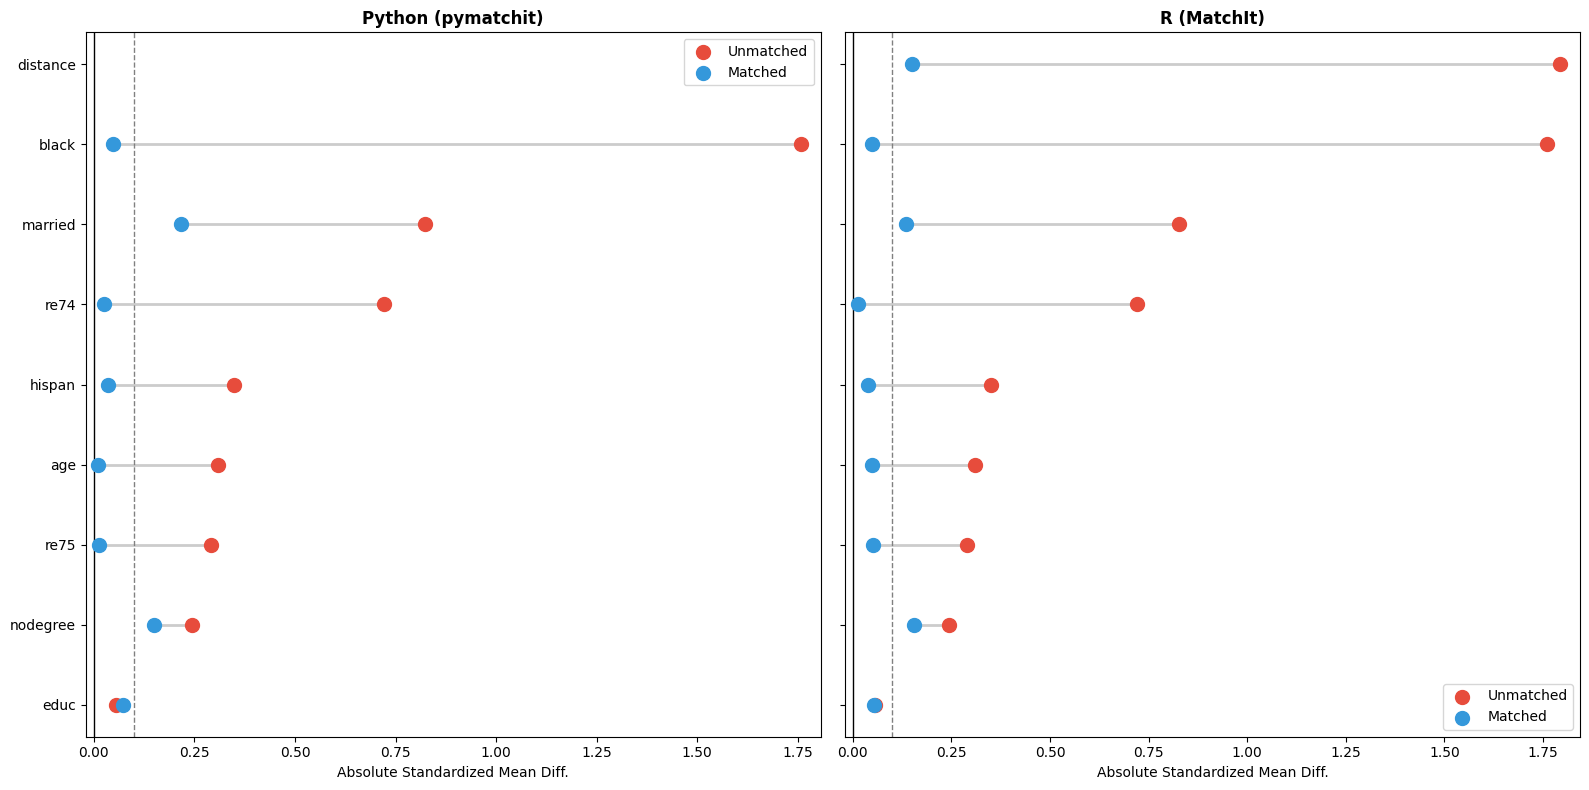

In [29]:
# 4. Create the Side-by-Side Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Python Plot
draw_love_plot_on_ax(
    axes[0], 
    py_unmatched, 
    py_matched, 
    title="Python (pymatchit)"
)

# R Plot
# Note: R might include the 'distance' (Propensity Score) in the summary.
# We can drop it to make the y-axis identical to Python if desired.
r_u_smd = r_unmatched_summary['Std. Mean Diff.']
r_m_smd = r_matched_summary['Std. Mean Diff.']

draw_love_plot_on_ax(
    axes[1], 
    r_u_smd, 
    r_m_smd, 
    title="R (MatchIt)"
)

plt.tight_layout()
plt.show()